# Relative Geometry - Students Arrangements

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
from functools import total_ordering
import bisect
from heapq import merge
from collections import Counter

In [2]:
class Pile(list):
    def __lt__(self, other): return self[-1] < other[-1]

    def __eq__(self, other): return self[-1] == other[-1]

#### Helping Functions

In [3]:
#calculates the last index of helper array = number of stacks
def get_last_idx(arr):
    if not arr: return -1
    i = 0
    while arr[i] != -1:
        i+=1
    
    return arr[i-1]

def get_LIS_by_row(df, idx):
    in_LIS = [0]*df.shape[0]
    while idx != -1:
        in_LIS[idx] = 1
        idx = df.loc[idx, 'angry'] 
    return in_LIS

In [4]:
def clean_df(df): 
    df.dropna(inplace=True)
    df.rename(columns = {'BagrutAverage':'gpa', 'Psycometric Mark':'sat'}, inplace = True)
    df = df[df['gpa']>0]
    df = df[df['sat']>0]
    df.sort_values("gpa", inplace = True)
    df = df.reset_index(drop=True)
    return df

In [5]:
#patience sort function - makes the stacks
def patience_sort_df(df, print_piles = 0, col="sat"):
    
    #this is 4 different arrays:
    piles = [] #the length is the number of piles, the number in each col is how many cards in the pile 
    pile_idx = []
    
    angry = [-1]*(df.shape[0])
    helper = [-1]*(df.shape[0])
    
    # sort into piles
    for index, row in df.iterrows():
        x = row["sat"]
        new_pile = Pile([x])

        i = bisect.bisect_right(piles, new_pile) #i is what pile to put the card

        pile_idx.append(i) #counts the number of piles

        #if the number of the pile does not exist - add another pile to piles[]
        if i != len(piles):
            piles[i].append(x)

        #if there is the wanted pile add - in each col there will be the number of cards    
        else:
            piles.append(new_pile)

        #this is the base for the LIS
        helper[i] = index #saves the last index of card in each pile 
        if i:
            angry[index] = helper[i-1] #after putting a card in the stack saves who was he angry about 

    
    #print("the helper is :" ,helper)
    last_idx = get_last_idx(helper) #gets the last index of the helper array = number of stacks
    #print("ths last index is:" ,last_idx)
    if print_piles: print(piles) 
    return (pile_idx, angry, last_idx) ## return: 1.number of piles ??, 2.the angry array, 3.number of piles ?? 

In [6]:
#makes the df_diamond
def diamond_branch(df):
    #1.make df_diamond
    df_diamond = df.copy(deep=True)
    in_diamond = [0]*df.shape[0]
    for index, row in df.iterrows():
        sat = row["sat"]
        gpa = row["gpa"]
        if (((sat-5*gpa) < 500) & ((sat+5*gpa) < 1100) & ((sat-5*gpa) > -100) & ((sat+5*gpa) > 500)):
            in_diamond[index] = 1
            
    df_diamond['in_diamond'] = in_diamond #add col
    df_diamond = df_diamond[df_diamond['in_diamond']>0] #leave only thoser that have 1
    df_diamond = df_diamond.drop('in_diamond', axis=1) #erases in_diamond col
    df_diamond = df_diamond.reset_index(drop=True)
    
    #2.call patience sort
    piles_idx, angry, last_idx = patience_sort_df(df_diamond, print_piles=0)
    df_diamond['pile'] = piles_idx
    df_diamond['angry'] = angry
    #put 1 if the number is part of the LIS
    in_LIS = get_LIS_by_row(df_diamond, last_idx)
    df_diamond['LIS'] = in_LIS
    return df_diamond

In [7]:
def create_piles_and_LIS(df, print_piles=0):
    piles_idx, angry, last_idx = patience_sort_df(df, print_piles=print_piles)
    #glue to the df 2 new col: 1.the pile of each card 2. who is he angry at 
    df['pile'] = piles_idx
    df['angry'] = angry

    #put 1 if the number is part of the LIS
    in_LIS = get_LIS_by_row(df, last_idx)
    df['LIS'] = in_LIS
    return df

In [8]:
def delete_piles(df, devided_by, inplace = 0):
    if not inplace:
        df_new_piles = df.copy(deep=True)
    else:
        df_new_piles = df
    to_delete = []
    for index, row in df_new_piles.iterrows():
        pile_num = abs(row['pile'])
        if pile_num%devided_by:
            to_delete.append(1)
        else:
            to_delete.append(0)
    df_new_piles['to_delete'] = to_delete
    df_new_piles = df_new_piles[df_new_piles['to_delete'] == 0]
    df_new_piles = df_new_piles.drop('to_delete', axis=1) #erases the added columns
    df_new_piles = df_new_piles.reset_index(drop=True)
    return df_new_piles

## Part 1 - Students and LIS Analysis

In [9]:
# load the dataset
df = pd.read_csv('Real Students Grades.csv')
students_df = clean_df(df)
df_diamond = diamond_branch(students_df)
students_df = create_piles_and_LIS(students_df)
students_df

,sat,gpa,pile,angry,LIS
0,427,56.95,0,-1,0
1,346,57.21,0,-1,0
2,586,57.35,1,1,0
3,414,58.19,1,1,0
4,366,58.77,1,1,0
...,...,...,...,...,...
136934,732,119.85,1962,136919,0
136935,693,119.90,1796,136914,0
136936,680,119.91,1705,136328,0
136937,734,119.94,1980,136894,0


In [10]:
piles_count = (max(students_df['pile'])+1)
print("number of piles: ", piles_count)

number of piles:  2023


In [11]:
LIS_df = students_df[(students_df['LIS'] == 1)]
LIS_df = LIS_df.drop(['pile','angry','LIS'], axis=1, inplace=False)
LIS_df.head(3)

,sat,gpa
71,314,64.83
118,326,66.00
130,329,66.30


In [12]:
students_df_dp = delete_piles(students_df, 20)
students_df_dp

,sat,gpa,pile,angry,LIS
0,427,56.95,0,-1,0
1,346,57.21,0,-1,0
2,334,64.09,0,-1,0
3,330,64.73,0,-1,0
4,314,64.83,0,-1,1
...,...,...,...,...,...
6833,735,118.33,1980,136846,0
6834,742,118.39,2000,136839,0
6835,766,118.54,2020,136878,1
6836,764,118.84,2020,136896,0


In [13]:
pile_count = len(np.unique(np.array(students_df_dp['pile'])))
pile_pallete = ['black']*pile_count

Text(0.5, 0, 'GPA score')

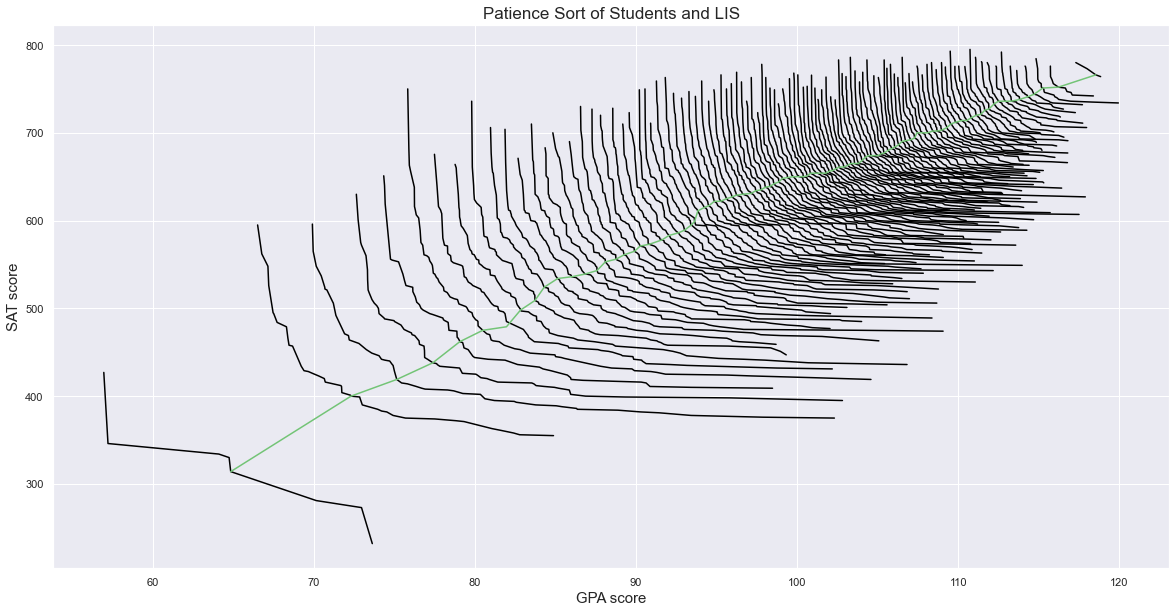

In [31]:
#printing regular patience sort
ax = sns.lineplot(data=students_df_dp, x="gpa", y="sat", hue="pile", palette=pile_pallete, markers=True, ci=None, legend=False)
sns.lineplot(data=students_df_dp.query("LIS == 1"), x="gpa", y="sat", hue="LIS", palette=('Greens'), ci=None, legend=False)
sns.set(rc = {'figure.figsize':(20,10)})
#ax.set_ylim(200, 800)
#ax.set_xlim(0, 120)
plt.title('Patience Sort of Students and LIS', size = 17)
plt.ylabel('SAT score', size = 15)
plt.xlabel('GPA score', size = 15)

## Part 2 - Diamond Relative Geometry

In [15]:
df_diamond.head()

,sat,gpa,pile,angry,LIS
0,427,56.95,0,-1,0
1,346,57.21,0,-1,0
2,586,57.35,1,1,0
3,414,58.19,1,1,0
4,366,58.77,1,1,0


In [16]:
#leave only 1 out of 10 for picture
df_diamond_dp = delete_piles(df_diamond, 10)
pile_count_d = len(np.unique(np.array(df_diamond_dp['pile'])))
pile_pallete_d = ['black']*pile_count_d

In [17]:
df_diamond_dp

,sat,gpa,pile,angry,LIS
0,427,56.95,0,-1,0
1,346,57.21,0,-1,0
2,597,62.87,10,29,0
3,548,63.32,10,36,0
4,547,63.46,10,39,0
...,...,...,...,...,...
4588,474,109.06,220,45455,0
4589,544,109.95,530,45503,0
4590,530,111.06,460,45537,0
4591,514,111.80,390,45547,0


Text(0.5, 0, 'GPA score')

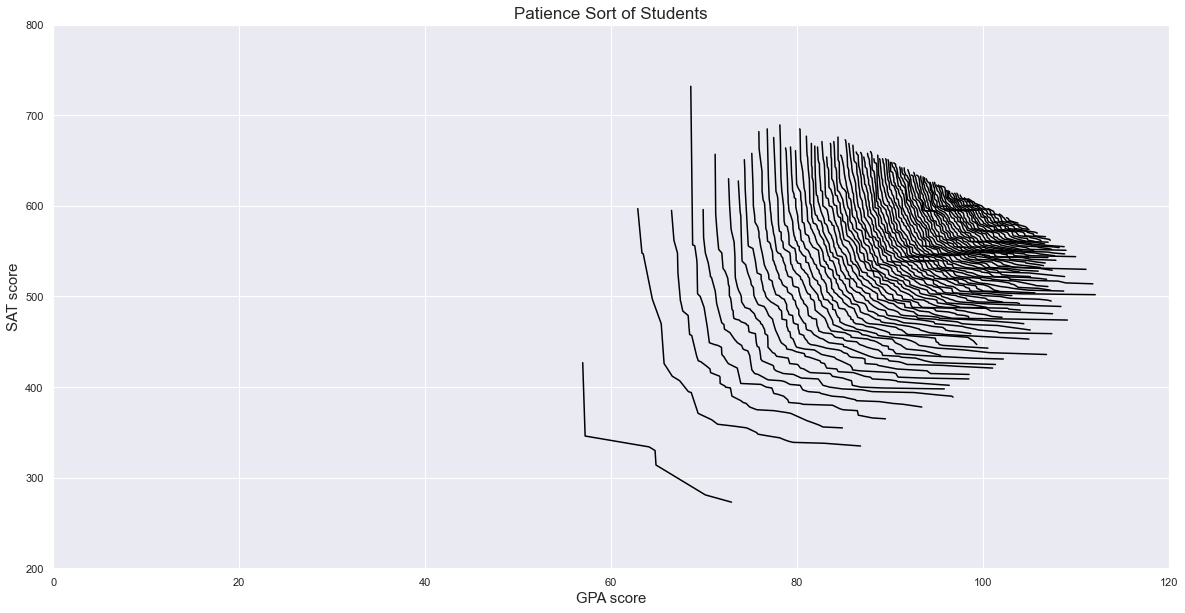

In [18]:
#printing diamond patience sort
ax = sns.lineplot(data=df_diamond_dp, x="gpa", y="sat", hue="pile", palette=pile_pallete_d, markers = True, ci= None, legend = False)
#sns.scatterplot(data=df_diamond.query("pile >= 0"), x="gpa", y="sat", hue="pile", palette=('Greys'), markers = True, ci= None)
sns.set(rc = {'figure.figsize':(20,10)})
ax.set_ylim(200, 800)
ax.set_xlim(0, 120)
plt.title('Patience Sort of Students', size = 17)
plt.ylabel('SAT score', size = 15)
plt.xlabel('GPA score', size = 15)

## Part 3 - Piles statistics - how many piles in a run

In [19]:
piles_count_lst = [max(students_df['pile'])+1, max(df_diamond['pile'])+1]
df_hist = pd.DataFrame.from_dict({'df_name': ['All Students', 'Diamond'], 'piles_count':piles_count_lst})
print("Number of Piles In Each Scenario")
df_hist

Number of Piles In Each Scenario


,df_name,piles_count
0,All Students,2023
1,Diamond,743


## Part 4 - Piles statistics - how many crads in each pile

In [20]:
#new main
pile, cards_in_pile = [], []
pile_d, cards_in_pile_d = [], []
    
counter = Counter(list(students_df['pile'])) # makes a counter object every pile how many cards in it 
cards_in_pile = list(counter.values())
pile = list(counter.keys()) 

counter_d = Counter(list(df_diamond['pile'])) # makes a counter object every pile how many cards in it 
cards_in_pile_d = list(counter_d.values())
pile_d = list(counter_d.keys()) 

#making the dicts and df towards printing
cards_dict = {'pile': pile, 'cards':cards_in_pile}
cards_df = pd.DataFrame.from_dict(cards_dict)
cards_dict_d = {'pile': pile_d, 'cards':cards_in_pile_d}
cards_df_d = pd.DataFrame.from_dict(cards_dict_d)
cards_df

,pile,cards
0,0,8
1,1,12
2,2,17
3,3,22
4,4,20
...,...,...
2018,2018,5
2019,2019,5
2020,2020,4
2021,2021,4


Text(0.5, 0, 'Pile Index')

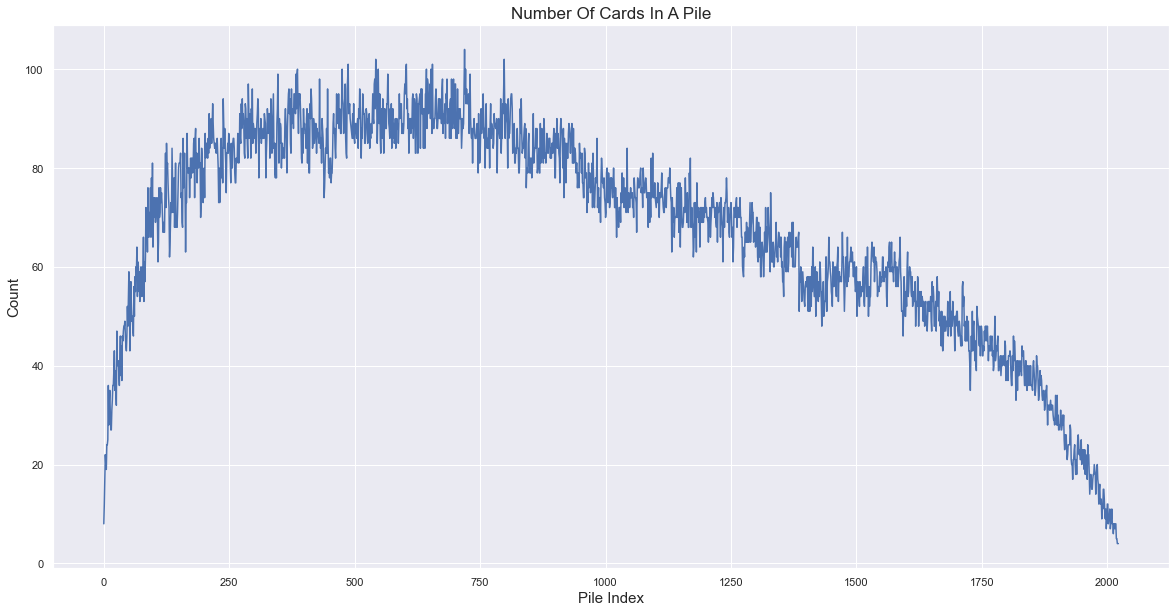

In [21]:
#print number of cards in pile regular students
sns.lineplot(data=cards_df, x="pile", y="cards", palette="deep", markers=True)
sns.set(rc = {'figure.figsize':(20,10)})
plt.title('Number Of Cards In A Pile', size = 17)
plt.ylabel('Count', size = 15)
plt.xlabel('Pile Index', size = 15)
#ax.set_xticks(range(0,max(pile),50));

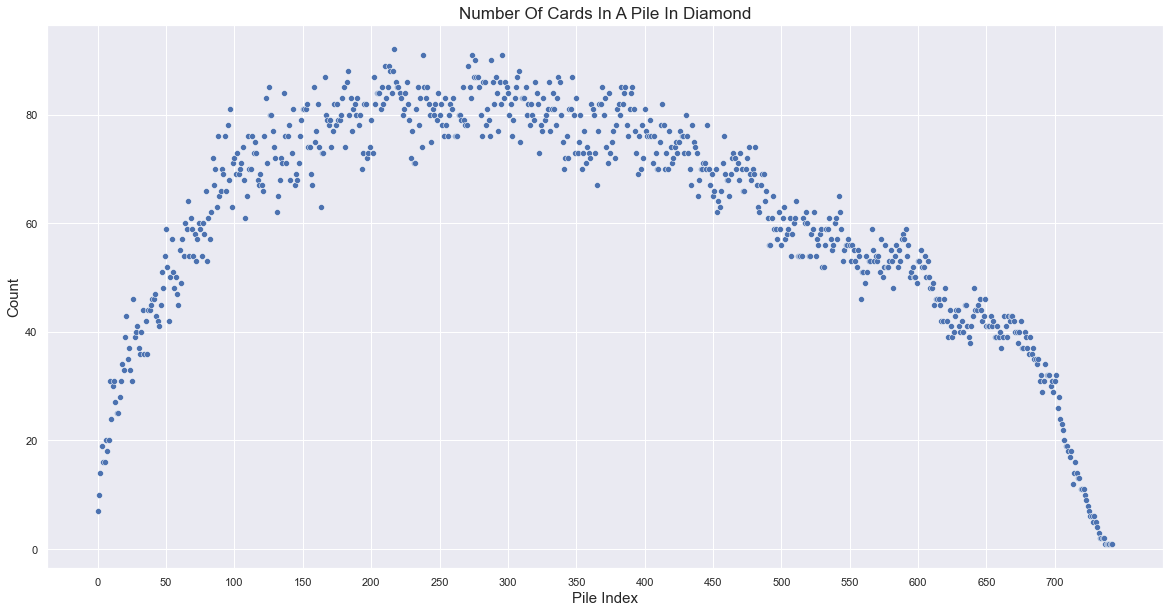

In [22]:
#print number of cards in pile diamond students 
ax = sns.scatterplot(data=cards_df_d, x="pile", y="cards", palette="deep", markers=True)
sns.set(rc = {'figure.figsize':(20,10)})
plt.title('Number Of Cards In A Pile In Diamond', size = 17)
plt.ylabel('Count', size = 15)
plt.xlabel('Pile Index', size = 15)
ax.set_xticks(range(0,max(pile_d),50));

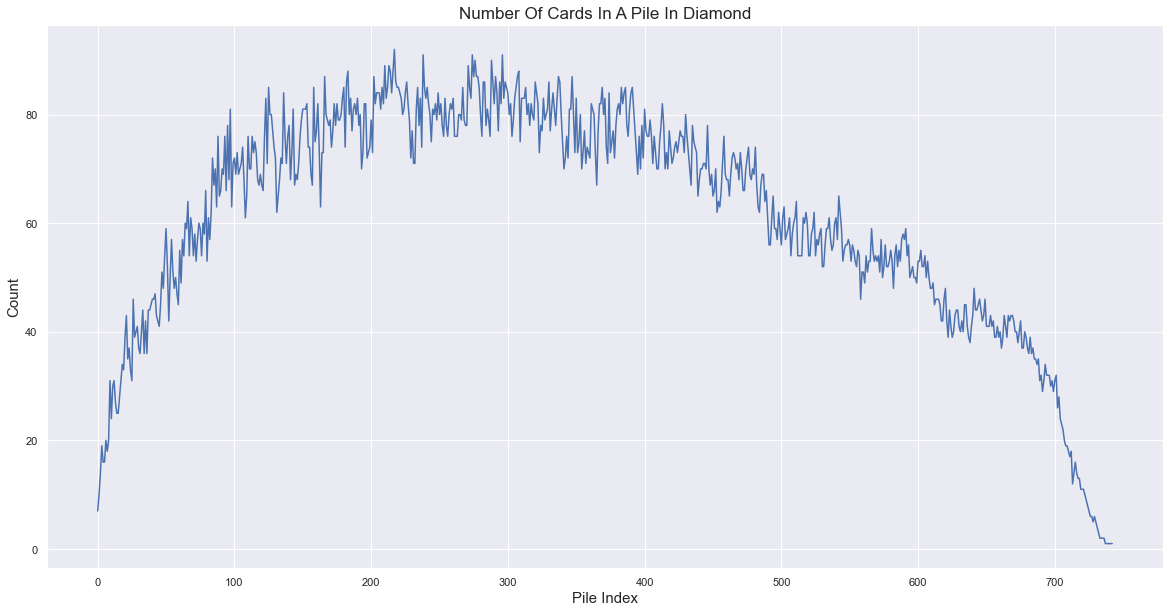

In [23]:
sns.lineplot(data=cards_df_d, x="pile", y="cards", palette="deep", markers=True)
sns.set(rc = {'figure.figsize':(20,10)})
plt.title('Number Of Cards In A Pile In Diamond', size = 17)
plt.ylabel('Count', size = 15)
plt.xlabel('Pile Index', size = 15)
ax.set_xticks(range(0,max(pile_d),50));

## Part 5 - Anti-diagonal Patience Sort 

#### Helping Functions

In [24]:
def split_AD(df):
    df_selection = [1]*df.shape[0]
    for index, row in df.iterrows():
        if (row["sat"]+5*row["gpa"]) < 800:
            df_selection[index] = 2
    #print(df_selection)
    df['df_selection'] = df_selection #add col
    df1, df2 = df.copy(), df.copy()
    df1 = df[df['df_selection']<2] #leave only those that have 1
    df1 = df1.drop('df_selection', axis=1) #erases col
    df1 = df1.reset_index(drop=True)
    df2 = df[df['df_selection']>1] #leave only those that have 1
    df2 = df2.drop('df_selection', axis=1) #erases col
    df2 = df2.sort_values("gpa", inplace = False, ascending = False)
    df2 = df2.reset_index(drop=True)
    return df1, df2

In [25]:
#patience sort function - makes the stacks
def patience_sort_2_piles(df, print_piles = 0, col="sat", gpa_high = 0):
    
    #this is 2 different arrays:
    piles = [] #the length is the number of piles, the number in each col is how many cards in the pile 
    pile_idx = []

    # sort into piles from lowest gpa
    if gpa_high == 0:
        for index, row in df.iterrows():
            x = row[col]
            new_pile = Pile([x])

            i = bisect.bisect_right(piles, new_pile) #i is what pile to put the card

            pile_idx.append(i) #counts the number of piles
            #if the number of the pile does not exist - add another pile to piles[]
            if i != len(piles):
                piles[i].append(x)
            #if there is the wanted pile add - in each col there will be the number of cards    
            else:
                piles.append(new_pile)

    # sort into piles from highest gpa
    else:
        #for index, row in df[::-1].iterrows():
        for index, row in df.iterrows():
            #print("-D- i: {} sat: {} gpa: {}".format(index, row["sat"], row["gpa"]))
            x = row['sat_opp']
            new_pile = Pile([x])

            i = bisect.bisect_right(piles, new_pile) #i is what pile to put the card
            #print("-D- i: {} sat: {} gpa: {} pile: {}".format(index, row["sat"], row["gpa"], i))

            pile_idx.append(i) #counts the number of piles

            #if the number of the pile does not exist - add another pile to piles[]
            if i != len(piles):
                piles[i].append(x)

            #if there is the wanted pile add - in each col there will be the number of cards    
            else:
                piles.append(new_pile)
        
    #if print_piles: print(piles) 
    return pile_idx ## return: 1.number of piles ??, 2.the angry array, 3.number of piles ?? 

In [26]:
#this function calls make_random_students and patience_sort_df and get_LIS_by_row
def create_two_df(df, print_piles=0): 
    df1, df2 = split_AD(df)
    #df1 actions
    piles_idx1 = patience_sort_2_piles(df1, print_piles=print_piles) 
    df1['pile'] = piles_idx1
    #df2 actions
    df2['sat_opp'] = 800-df2['sat']
    piles_idx2 = patience_sort_2_piles(df2, print_piles=print_piles, col='sat_opp', gpa_high = 1)
    piles_idx2 = [(-(i+1)) for i in piles_idx2]
    df2['pile'] = piles_idx2
    #print(" the df2 after patience looks like:\n", df2)
    df2 = df2.drop(['sat_opp'], axis=1) #erases sat_opp col
    
    return df1, df2

In [27]:
#like main
#count_piles, count_piles_d = [], []
#num_trials = 1
#for i in range(num_trials):
df1, df2 = create_two_df(students_df)#makes the two df
df_union = pd.concat([df1, df2])
df_union_dp = delete_piles(df_union, devided_by=10)
df_union_dp

,sat,gpa,pile,angry,LIS
0,586,57.35,0,1,0
1,541,60.25,0,7,0
2,527,60.48,0,10,0
3,510,60.63,0,10,0
4,509,61.95,0,22,0
...,...,...,...,...,...
13703,363,65.90,-40,57,0
13704,372,64.90,-40,50,0
13705,420,64.70,-20,65,0
13706,433,62.86,-10,30,0


In [28]:
pile_count = len(np.unique(np.array(df_union_dp.query("pile >= 0")['pile'])))
pile_pallete_up = ['black']*pile_count

pile_count = len(np.unique(np.array(df_union_dp.query("pile < 0")['pile'])))
pile_pallete_down = ['blue']*pile_count

Text(0.5, 0, 'GPA score')

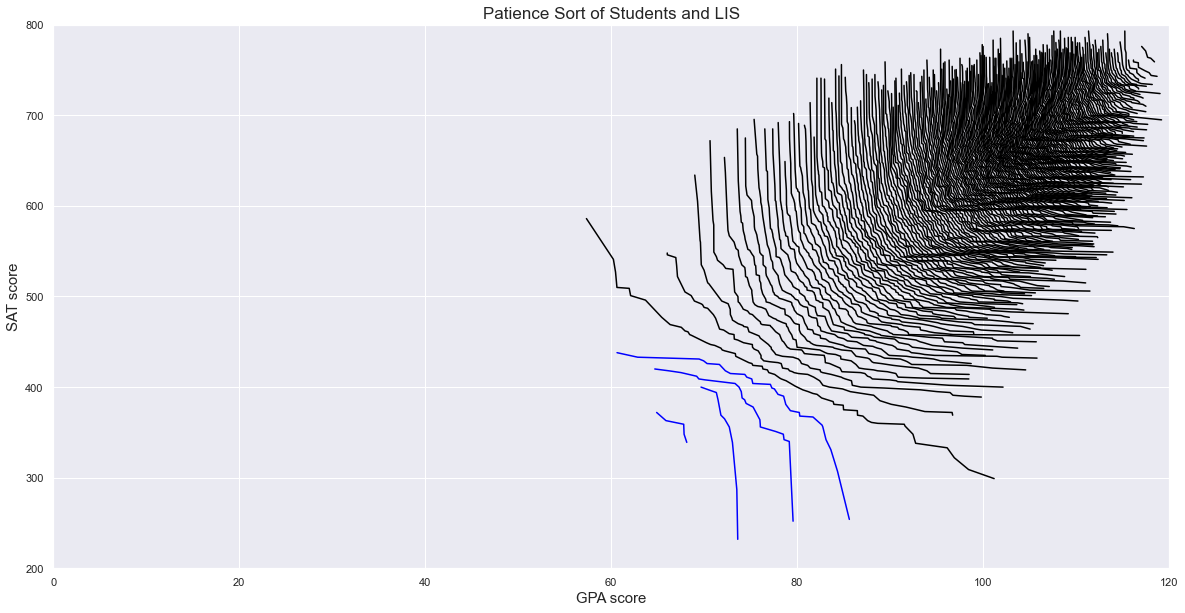

In [29]:
#printing regular patience sort
ax = sns.lineplot(data=df_union_dp.query("pile >= 0"), x="gpa", y="sat", hue="pile", palette=pile_pallete_up, markers = True, ci= None, legend = False)
sns.lineplot(data=df_union_dp.query("pile < 0"), x="gpa", y="sat", hue="pile", palette=pile_pallete_down, markers = True, ci= None, legend = False)
ax.set_ylim(200, 800)
ax.set_xlim(0, 120)
sns.set(rc = {'figure.figsize':(20,10)})
plt.title('Patience Sort of Students and LIS', size = 17)
plt.ylabel('SAT score', size = 15)
plt.xlabel('GPA score', size = 15)